In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC, LinearSVC
#import pandas_profiling
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost as xgb

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

# EDA

In [3]:
pandas_profiling.ProfileReport(train_df)

NameError: name 'pandas_profiling' is not defined

We take following features into account in our model.
Numerical features: Age, Fare, Parch, SibSp
Categorical features: Pclass, Sex, Embarked

In [4]:
numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Embarked', 'Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [5]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]

In [6]:
random_state = 1        # Fixate a random state so that the results are reproducible
n_jobs = -1

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state)
    ]

kfold = StratifiedKFold(n_splits=5)
cross_val_results = []   
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    cv_score = cross_val_score(pipe, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    cross_val_results.append(cv_score)
    print(classifier)
    print(cv_score)

KNeighborsClassifier(n_neighbors=3)
[0.77094972 0.75842697 0.80898876 0.80898876 0.80337079]
LogisticRegression(random_state=1)
[0.77653631 0.78651685 0.78651685 0.76966292 0.83146067]
RandomForestClassifier(random_state=1)
[0.78212291 0.80337079 0.83707865 0.78651685 0.8258427 ]
DecisionTreeClassifier(random_state=1)
[0.75977654 0.80337079 0.79213483 0.73595506 0.80898876]


In [7]:
cv_means = []    # Returns the means of the n-fold cross val results
for cv in cross_val_results:
    cv_means.append(cv.mean())
    
print(cv_means)

[0.7901450003138535, 0.7901387232439896, 0.8069863787583955, 0.7800451949030192]


/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


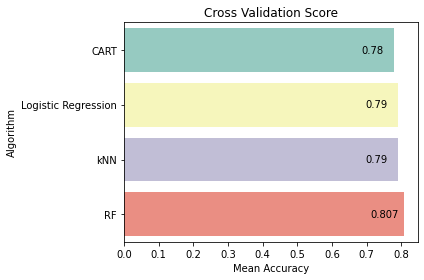

In [8]:
cv_res = pd.DataFrame({"Cross Val Means":cv_means, "Algorithm":["kNN", "Logistic Regression", "RF", "CART"]})
order = cv_res.sort_values('Cross Val Means') 
g = sns.barplot("Cross Val Means","Algorithm",data = cv_res, order=order['Algorithm'], palette="Set3",orient = "h")

for i in g.patches:         # Put labels on bars
    width = i.get_width()-(i.get_width()*0.12)        # Put labels left of the end of the bar
    g.text(width, i.get_y() + i.get_height()/2, round(i.get_width(),3), color='black', va="center")
    
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Validation Score")
plt.tight_layout()  
plt.show()

## See how well our random forest predicts the test dataset

In [9]:
pipe_best_pred = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifiers[2])])
pipe_best_pred.fit(X_train, Y_train)
test_pred = pipe_best_pred.predict(test_df)

In [10]:
pipe_best_pred

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Parch',
                                                   'SibSp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]

In [11]:
test_pred_col = pd.Series(test_pred, name='Survived')
submission = pd.concat([test_df['PassengerId'], test_pred_col], axis=1)
submission.to_csv("randomForest.csv", index=False)

## Improve RF model with hyperparameters

In [29]:
pipe_best_pred.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    ['Age', 'Fare', 'Parch', 'SibSp']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['Embarked', 'Sex', 'Pclass'])])),
  ('classifier', RandomForestClassifier(random_state=1))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pip

In [12]:
pipe_best_pred = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifiers[2])])
param_grid = {"classifier__max_features": [1, 3, 10],
              "classifier__min_samples_split": [2, 3, 10],
              "classifier__min_samples_leaf": [1, 3, 10],
              "classifier__n_estimators" :[100,300]}

gs_rf = GridSearchCV(pipe_best_pred, param_grid = param_grid, cv=kfold, scoring="accuracy", verbose = 1, n_jobs = -1)
gs_rf.fit(X_train, Y_train)

rf_best = gs_rf.best_estimator_.named_steps['classifier']

print('Best parameters found: ', gs_rf.best_params_)
print('Best estimator found: ', rf_best)
print('Best score found: ', gs_rf.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   14.7s finished


Best parameters found:  {'classifier__max_features': 10, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best estimator found:  RandomForestClassifier(max_features=10, min_samples_leaf=3,
                       min_samples_split=10, random_state=1)
Best score found:  0.8361747536250078


In [13]:
test_pred_impr_rf = gs_rf.predict(test_df)
test_pred_impr_rf

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [14]:
test_pred_impr_rf_col = pd.Series(test_pred_impr_rf, name='Survived')
submission = pd.concat([test_df['PassengerId'], test_pred_impr_rf_col], axis=1)
submission.to_csv("improvedRandomForest.csv", index=False)

## XGBoost model

In [15]:
xgb_cl = xgb.XGBClassifier(random_state=random_state, learning_rate=0.01)
xgb_pred = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb_cl)])
    
cv_score_xgb = cross_val_score(xgb_pred, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
print(cv_score_xgb)
print(cv_score_xgb.mean())

[0.81005587 0.81460674 0.88764045 0.79775281 0.84269663]
0.8305504990270542


In [16]:
xgb_pred.fit(X_train, Y_train)
test_pred_xgb = xgb_pred.predict(test_df)
test_pred_xgb

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [17]:
test_pred_xgb_col = pd.Series(test_pred_xgb, name='Survived')
submission = pd.concat([test_df['PassengerId'], test_pred_xgb_col], axis=1)
submission.to_csv("XGBoost.csv", index=False)

## Improved XGBoost

In [18]:
xgb_pred.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    ['Age', 'Fare', 'Parch', 'SibSp']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['Embarked', 'Sex', 'Pclass'])])),
  ('classifier',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
      

In [22]:
param_grid_xgb = {"classifier__max_depth": range(1,10),
                  "classifier__min_child_weight": range(1,3),
                  "classifier__subsample": [0.3, 0.5, 1],
                  "classifier__max_delta_step": range(0,2)
                 }

gs_xgb = GridSearchCV(xgb_pred, param_grid = param_grid_xgb, cv=kfold, scoring="accuracy", verbose = 1, n_jobs = -1)
gs_xgb.fit(X_train, Y_train)

xgb_best = gs_xgb.best_estimator_.named_steps['classifier']

print('Best parameters found: ', gs_xgb.best_params_)
print('Best estimator found: ', xgb_best)
print('Best score found: ', gs_xgb.best_score_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 6840 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9440 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 10912 out of 10935 | elapsed:  2.2min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 10935 out of 10935 | elapsed:  2.2min finished


Best parameters found:  {'classifier__max_delta_step': 2, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__subsample': 1}
Best estimator found:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=2, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best score found:  0.8305504990270542


In [24]:
test_pred_impr_xgb = gs_xgb.predict(test_df)

test_pred_impr_xgb_col = pd.Series(test_pred_impr_xgb, name='Survived')
submission = pd.concat([test_df['PassengerId'], test_pred_impr_xgb_col], axis=1)
submission.to_csv("improvedXGBoost.csv", index=False)